In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [13]:
used_song_cols = ['track_id', 'user_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre']

common_df = pd.read_csv('./data/processed_data/common.csv')
data = common_df[used_song_cols].drop_duplicates(subset=['track_name', 'artists']).reset_index(drop=True)

In [18]:
print('there ars {} user-song clicks in our data'.format(common_df.shape[0]))
print('there ars {} songs in our data'.format(common_df.song_label.nunique()))
print('there ars {} users in our data'.format(common_df.user_id.nunique()))

there ars 872617 user-song clicks in our data
there ars 14758 songs in our data
there ars 14359 users in our data


# Heatmap of numerical features

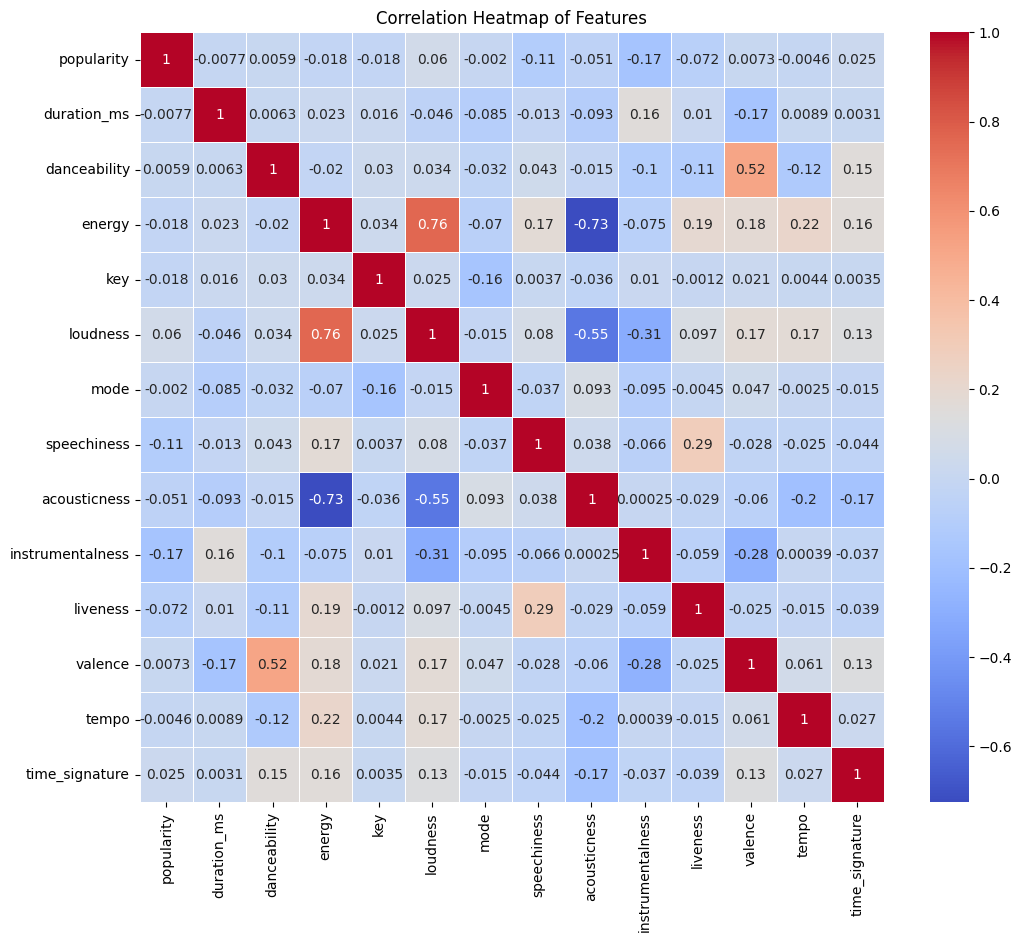

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

correlation_matrix = data[features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()


From the plot, we noticed there is high correlation between energy and loudness as well as acousticness.  
This suggests only one feature is needed when evaluating a song from the angle of energy and loudness/ acousticness.  
Therefore we choose to drop 'energy' in our model.

Then we want to look at if different genres have extinct performances in the features.  
So we use cluster as well as PCA to visualize the plot and reduce the large demensions.

# 2-D Cluster Plot of Random 20 Genres

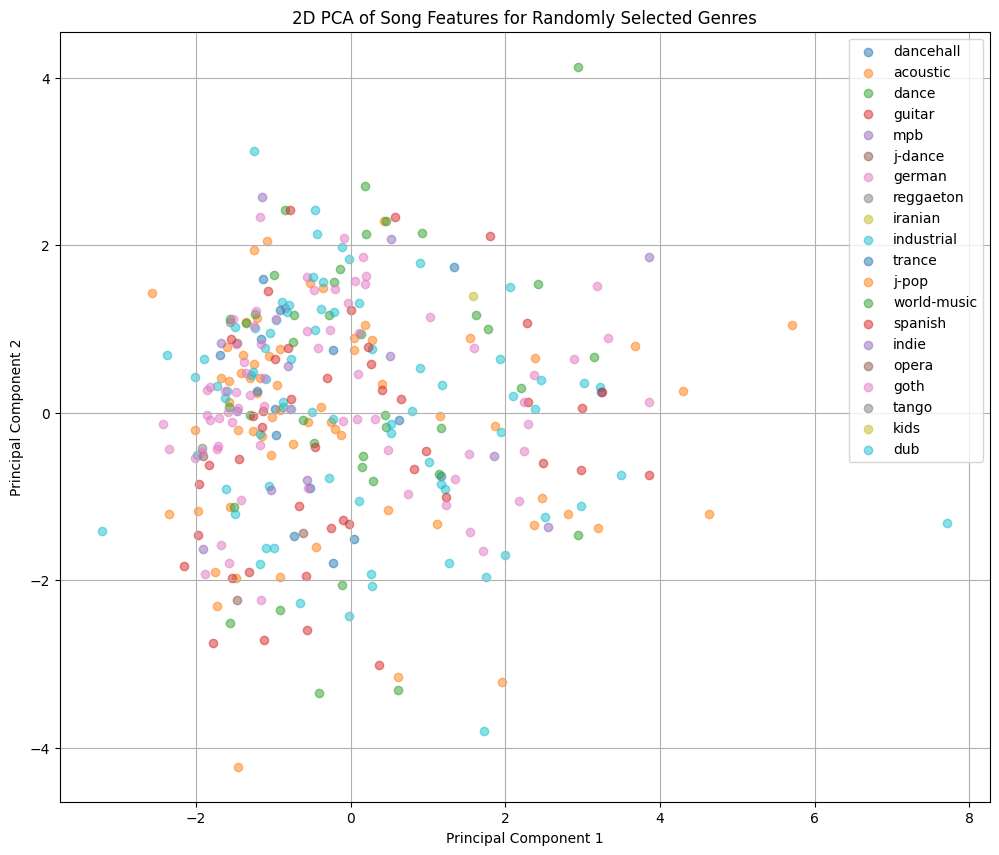

In [20]:
import random
unique_genres = data['track_genre'].unique()
random_genres = random.sample(list(unique_genres), 20)
data_filtered = data[data['track_genre'].isin(random_genres)]

cluster_data = data_filtered[features]

# Standardizing the features
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# Applying PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cluster_scaled)

# Creating a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Genre'] = data_filtered['track_genre']  # Adding the genre information

# Visualizing the data in 2D, colored by genre
plt.figure(figsize=(12, 10))

for genre in random_genres:
    genre_data = pca_df[pca_df['Genre'] == genre]
    plt.scatter(genre_data['PC1'], genre_data['PC2'], label=genre, alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Song Features for Randomly Selected Genres')
plt.legend()
plt.grid(True)
plt.show()


According to the plot, the dots scatter randomly and there is no evident group.  
This suggests there might be high variability within each genre's features.  
So far we choose not to drop any specific features.

###
## Explore Popularity

In [21]:
genre_likes_count = data['track_genre'].value_counts()
top_genres = genre_likes_count.head(10)
top_genres

track_genre
grunge        509
industrial    495
power-pop     456
trip-hop      454
goth          333
psych-rock    331
bluegrass     326
ska           318
synth-pop     314
grindcore     308
Name: count, dtype: int64

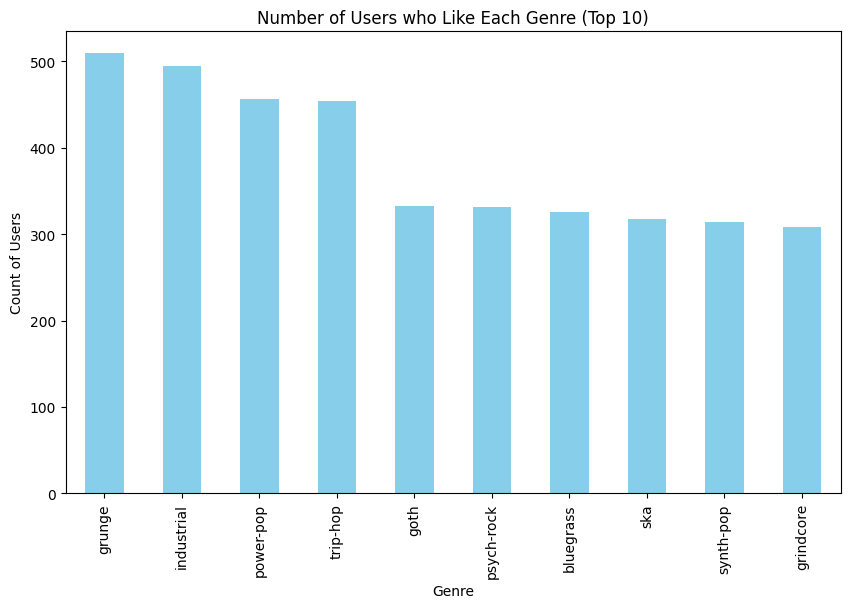

In [22]:
# Plot the counts for the first 10 genres
plt.figure(figsize=(10, 6))
top_genres.plot(kind='bar', color='skyblue')
plt.title('Number of Users who Like Each Genre (Top 10)')
plt.xlabel('Genre')
plt.ylabel('Count of Users')
plt.show()

The most popular genres are shown. It seems that rock music are welcomed most.

### Next we use the method of SHAP Values to see how these features influence the popularity of a song.

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[22:35:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


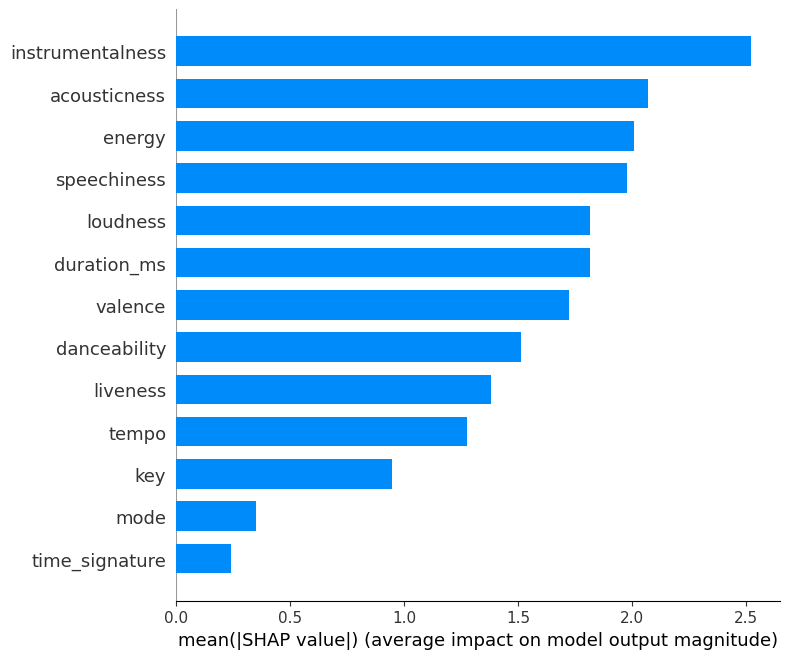

In [25]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
# Selecting features and target
features1 = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 
            'mode', 'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo', 'time_signature']  
X = data[features1]
y = data['popularity']  # Replace with your target column

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training an XGBoost model
xgb_mod = xgb.XGBRegressor(objective ='reg:squarederror')
xgb_mod.fit(X_train, y_train)

# Using SHAP to explain feature contributions
explainerXGB = shap.TreeExplainer(xgb_mod)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

# Creating DataFrames for SHAP values
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

# Plotting the SHAP values
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")


It shows that instrumentalness, acousticness, valence, enerygy are features that have largest influence on popularity.

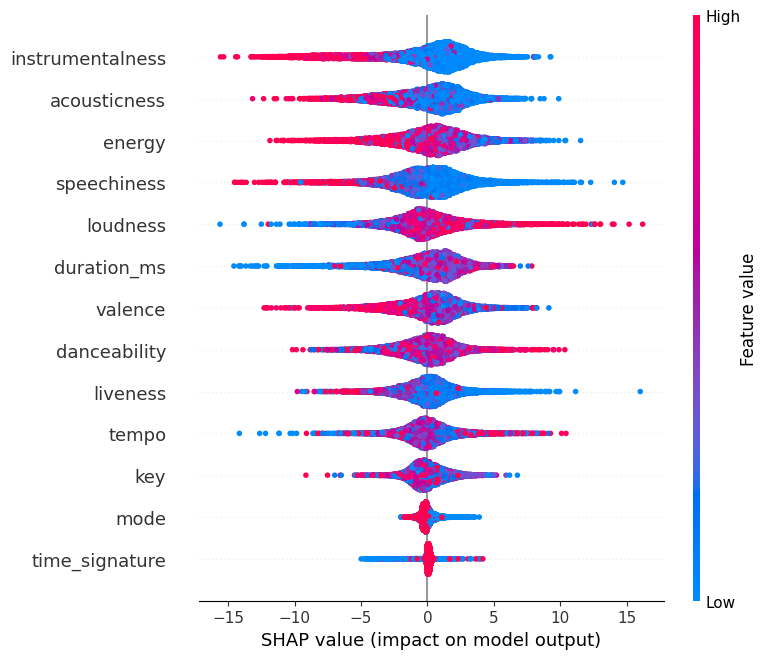

In [26]:
shap.summary_plot(shap_values_XGB_train, X_train)

In order to let users have more common choices on the streamlit app,   
we choose to randomly select 10 songs whose popularity >=80 to serve as a region.

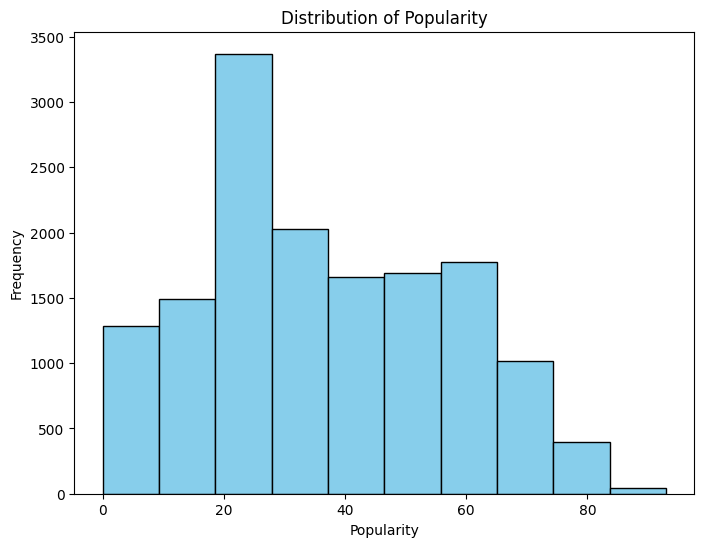

In [27]:
plt.figure(figsize=(8, 6))
plt.hist(data['popularity'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Distribution of Popularity')
plt.show()

In [28]:
pop_count1 = (data['popularity'] >= 70).sum()
pop_count2 = (data['popularity'] >= 80).sum()
pop_count1, pop_count2

(944, 157)

Also we want to check if the top 10 popular genres obtained from our merged data match the 'popularity' in data provided by Spotify.

In [29]:
# Calculating the average popularity of songs for each genre
average_popularity_per_genre = data.groupby('track_genre')['popularity'].mean()
top_genres_by_popularity = average_popularity_per_genre.sort_values(ascending=False).head(10)


# Comparing with the top genres by count
comparison_df = pd.DataFrame({
    'Genres by Count': top_genres.index,
    'Genres by Popularity': top_genres_by_popularity.index
})

comparison_df

,Genres by Count,Genres by Popularity
0,grunge,hip-hop
1,industrial,singer-songwriter
2,power-pop,chill
3,trip-hop,pop-film
4,goth,metal
5,psych-rock,hard-rock
6,bluegrass,k-pop
7,ska,folk
8,synth-pop,funk
9,grindcore,emo


We can see there is a mismatch in the popular genres.  
It probably arises from the limited size of our users' dataset.

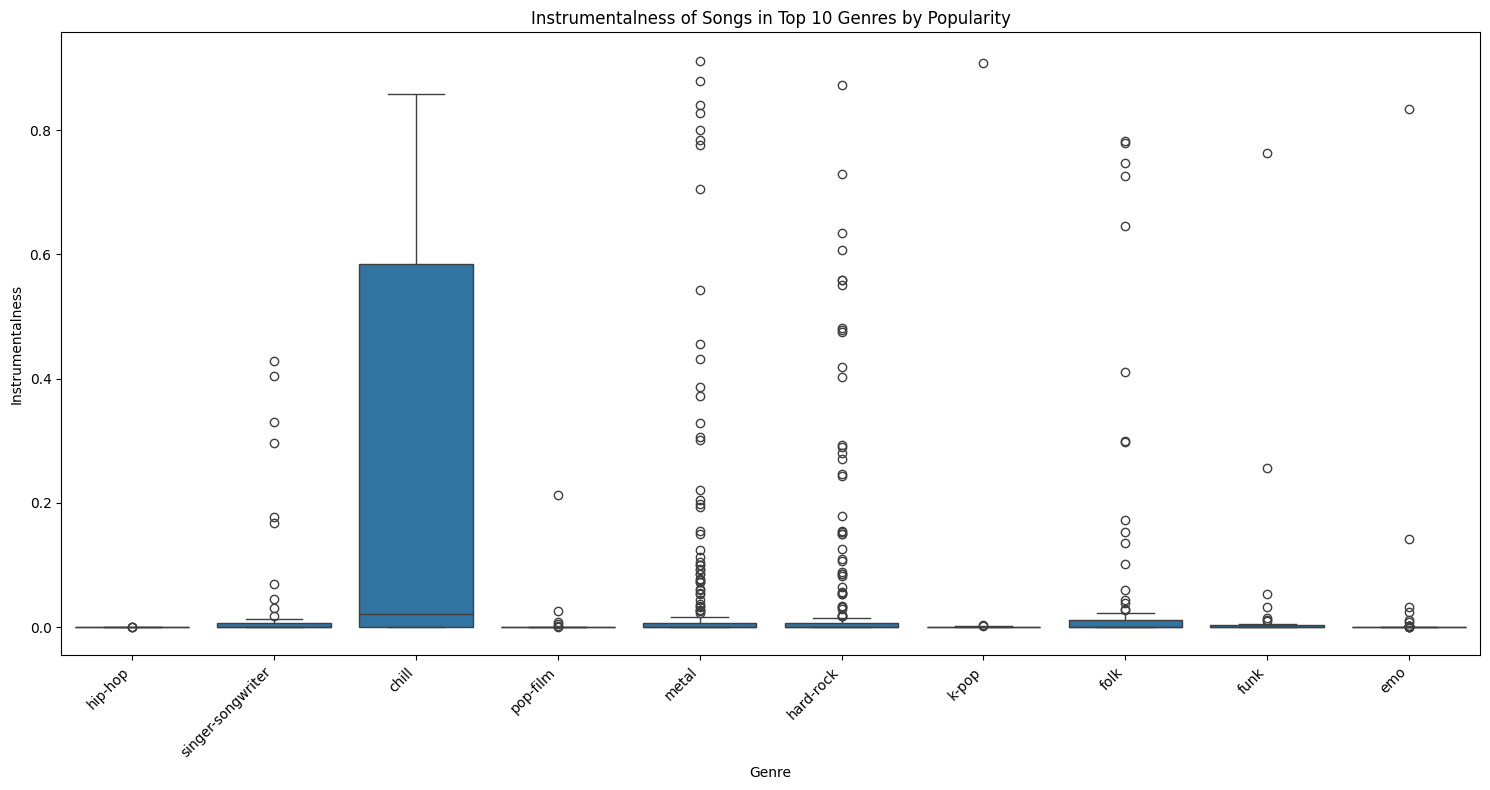

In [30]:
# Filtering the dataset to include only songs from the top 10 genres by popularity
top_genres_by_popularity_df = data[data['track_genre'].isin(top_genres_by_popularity.index)]

# Creating a box plot for the instrumentalness of songs in the top 10 genres by popularity
plt.figure(figsize=(15, 8))
sns.boxplot(x="track_genre", y="instrumentalness", data=top_genres_by_popularity_df, order=top_genres_by_popularity.index)
plt.xticks(rotation=45, ha="right")
plt.title("Instrumentalness of Songs in Top 10 Genres by Popularity")
plt.xlabel("Genre")
plt.ylabel("Instrumentalness")
plt.tight_layout()
plt.show()

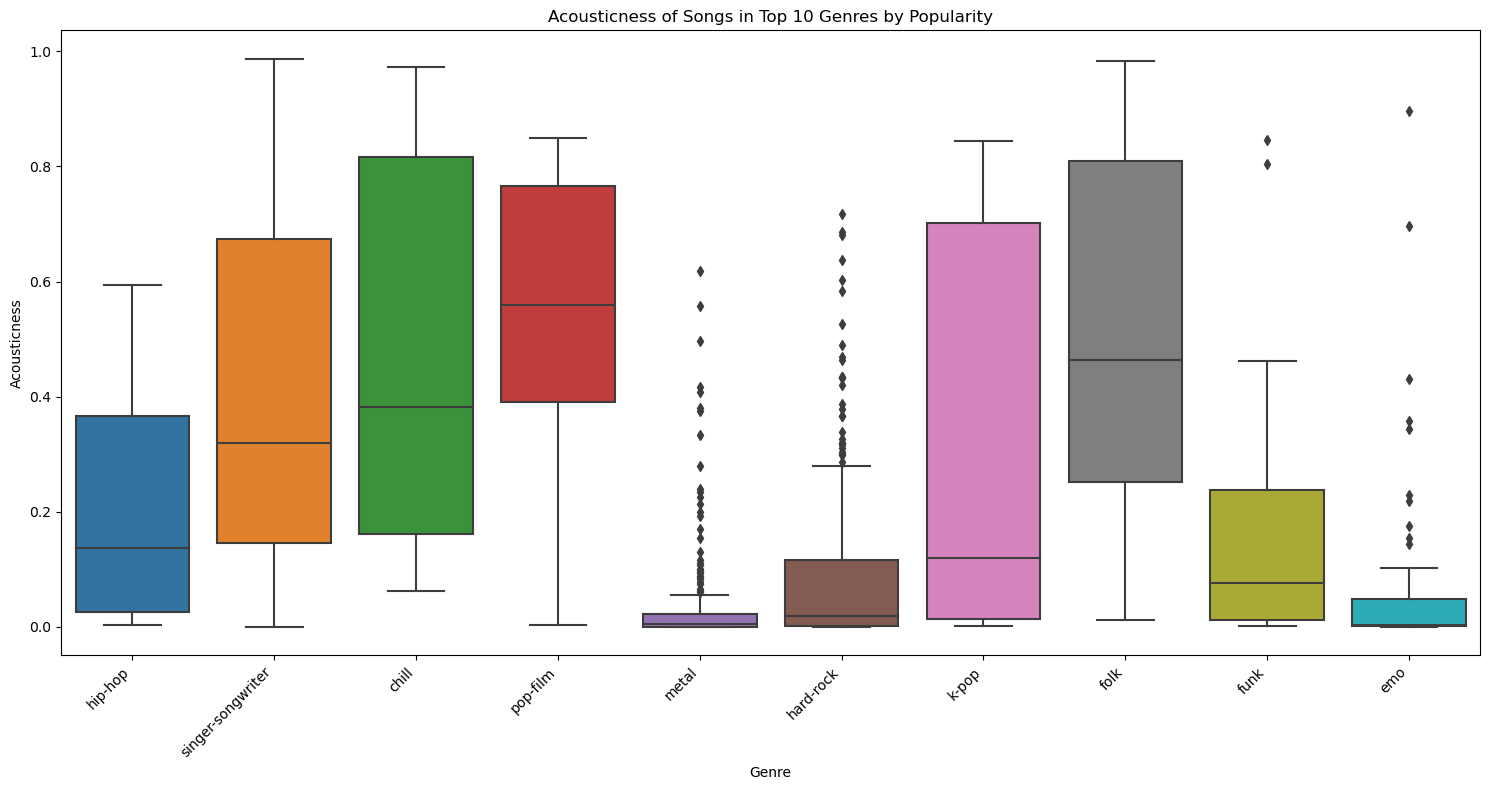

In [23]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="track_genre", y="acousticness", data=top_genres_by_popularity_df, order=top_genres_by_popularity.index)
plt.xticks(rotation=45, ha="right")
plt.title("Acousticness of Songs in Top 10 Genres by Popularity")
plt.xlabel("Genre")
plt.ylabel("Acousticness")
plt.tight_layout()
plt.show()

We try to prove the guess that most popular genres may have similar performance in instrumentalness.  
But it doesn't turn out that way.